## Assignment 4 Shuhao Liu Part 1 - Apriori

We begin by including the functions to generate frequent itemsets (via the Apriori algorithm) and resulting association rules:

### To load our dataset of grocery transactions, use the command below

In [2]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
dataset = load_dataset('grocery.csv')
D = list(map(set, dataset))

### _dataset_ is now a ndarray containing each of the 9835 transactions

In [1]:
# (c) 2016 Everaldo Aguiar & Reid Johnson
#
# Modified from:
# Marcel Caraciolo (https://gist.github.com/marcelcaraciolo/1423287)
#
# Functions to compute and extract association rules from a given frequent itemset 
# generated by the Apriori algorithm.
#
# The Apriori algorithm is defined by Agrawal and Srikant in:
# Fast algorithms for mining association rules
# Proc. 20th int. conf. very large data bases, VLDB. Vol. 1215. 1994
import csv
import numpy as np

def load_dataset(filename):
    '''Loads an example of market basket transactions from a provided csv file.

    Returns: A list (database) of lists (transactions). Each element of a transaction is 
    an item.
    '''

    with open(filename,'r') as dest_f:
        data_iter = csv.reader(dest_f, delimiter = ',', quotechar = '"')
        data = [data for data in data_iter]
        data_array = np.asarray(data)
        
    return data_array

def apriori(dataset, min_support=0.5, verbose=False):
    """Implements the Apriori algorithm.

    The Apriori algorithm will iteratively generate new candidate 
    k-itemsets using the frequent (k-1)-itemsets found in the previous 
    iteration.

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate 
        candidate itemsets.

    min_support : float
        The minimum support threshold. Defaults to 0.5.

    Returns
    -------
    F : list
        The list of frequent itemsets.

    support_data : dict
        The support data for all candidate itemsets.

    References
    ----------
    .. [1] R. Agrawal, R. Srikant, "Fast Algorithms for Mining Association 
           Rules", 1994.

    """
    C1 = create_candidates(dataset)
    D = list(map(set, dataset))
    F1, support_data = support_prune(D, C1, min_support, verbose=False) # prune candidate 1-itemsets
    F = [F1] # list of frequent itemsets; initialized to frequent 1-itemsets
    k = 2 # the itemset cardinality
    while (len(F[k - 2]) > 0):
        Ck = apriori_gen(F[k-2], k) # generate candidate itemsets
        Fk, supK = support_prune(D, Ck, min_support) # prune candidate itemsets
        support_data.update(supK) # update the support counts to reflect pruning
        F.append(Fk) # add the pruned candidate itemsets to the list of frequent itemsets
        k += 1

    if verbose:
        # Print a list of all the frequent itemsets.
        for kset in F:
            for item in kset:
                print("" \
                    + "{" \
                    + "".join(str(i) + ", " for i in iter(item)).rstrip(', ') \
                    + "}" \
                    + ":  sup = " + str(round(support_data[item], 3)))

    return F, support_data

def create_candidates(dataset, verbose=False):
    """Creates a list of candidate 1-itemsets from a list of transactions.

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate candidate 
        itemsets.

    Returns
    -------
    The list of candidate itemsets (c1) passed as a frozenset (a set that is 
    immutable and hashable).
    """
    c1 = [] # list of all items in the database of transactions
    for transaction in dataset:
        for item in transaction:
            if not [item] in c1:
                c1.append([item])
    c1.sort()

    if verbose:
        # Print a list of all the candidate items.
        print("" \
            + "{" \
            + "".join(str(i[0]) + ", " for i in iter(c1)).rstrip(', ') \
            + "}")

    # Map c1 to a frozenset because it will be the key of a dictionary.
    return list(map(frozenset, c1))

def support_prune(dataset, candidates, min_support, verbose=False):
    """Returns all candidate itemsets that meet a minimum support threshold.

    By the apriori principle, if an itemset is frequent, then all of its 
    subsets must also be frequent. As a result, we can perform support-based 
    pruning to systematically control the exponential growth of candidate 
    itemsets. Thus, itemsets that do not meet the minimum support level are 
    pruned from the input list of itemsets (dataset).

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate candidate 
        itemsets.

    candidates : frozenset
        The list of candidate itemsets.

    min_support : float
        The minimum support threshold.

    Returns
    -------
    retlist : list
        The list of frequent itemsets.

    support_data : dict
        The support data for all candidate itemsets.
    """
    sscnt = {} # set for support counts
    for tid in dataset:
        for can in candidates:
            if can.issubset(tid):
                sscnt.setdefault(can, 0)
                sscnt[can] += 1

    num_items = float(len(dataset)) # total number of transactions in the dataset
    retlist = [] # array for unpruned itemsets
    support_data = {} # set for support data for corresponding itemsets
    for key in sscnt:
        # Calculate the support of itemset key.
        support = sscnt[key] / num_items
        if support >= min_support:
            retlist.insert(0, key)
        support_data[key] = support

    # Print a list of the pruned itemsets.
    if verbose:
        for kset in retlist:
            for item in kset:
                print("{" + str(item) + "}")
        print("")
        for key in sscnt:
            print("" \
                + "{" \
                + "".join([str(i) + ", " for i in iter(key)]).rstrip(', ') \
                + "}" \
                + ":  sup = " + str(support_data[key]))

    return retlist, support_data

def apriori_gen(freq_sets, k):
    """Generates candidate itemsets (via the F_k-1 x F_k-1 method).

    This operation generates new candidate k-itemsets based on the frequent 
    (k-1)-itemsets found in the previous iteration. The candidate generation 
    procedure merges a pair of frequent (k-1)-itemsets only if their first k-2 
    items are identical.

    Parameters
    ----------
    freq_sets : list
        The list of frequent (k-1)-itemsets.

    k : integer
        The cardinality of the current itemsets being evaluated.

    Returns
    -------
    retlist : list
        The list of merged frequent itemsets.
    """
    retList = [] # list of merged frequent itemsets
    lenLk = len(freq_sets) # number of frequent itemsets
    for i in range(lenLk):
        for j in range(i+1, lenLk):
            a=list(freq_sets[i])
            b=list(freq_sets[j])
            a.sort()
            b.sort()
            F1 = a[:k-2] # first k-2 items of freq_sets[i]
            F2 = b[:k-2] # first k-2 items of freq_sets[j]

            if F1 == F2: # if the first k-2 items are identical
                # Merge the frequent itemsets.
                retList.append(freq_sets[i] | freq_sets[j])

    return retList

def rules_from_conseq(freq_set, H, support_data, rules, min_confidence=0.5, verbose=False):
    """Generates a set of candidate rules.

    Parameters
    ----------
    freq_set : frozenset
        The complete list of frequent itemsets.

    H : list
        A list of frequent itemsets (of a particular length).

    support_data : dict
        The support data for all candidate itemsets.

    rules : list
        A potentially incomplete set of candidate rules above the minimum 
        confidence threshold.

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.
    """
    m = len(H[0])
    if m == 1:
        Hmp1 = calc_confidence(freq_set, H, support_data, rules, min_confidence, verbose)
    if (len(freq_set) > (m+1)):
        Hmp1 = apriori_gen(H, m+1) # generate candidate itemsets
        Hmp1 = calc_confidence(freq_set, Hmp1, support_data, rules, min_confidence, verbose)
        if len(Hmp1) > 1:
            # If there are candidate rules above the minimum confidence 
            # threshold, recurse on the list of these candidate rules.
            rules_from_conseq(freq_set, Hmp1, support_data, rules, min_confidence, verbose)

def calc_confidence(freq_set, H, support_data, rules, min_confidence=0.5, verbose=False):
    """Evaluates the generated rules.

    One measurement for quantifying the goodness of association rules is 
    confidence. The confidence for a rule 'P implies H' (P -> H) is defined as 
    the support for P and H divided by the support for P 
    (support (P|H) / support(P)), where the | symbol denotes the set union 
    (thus P|H means all the items in set P or in set H).

    To calculate the confidence, we iterate through the frequent itemsets and 
    associated support data. For each frequent itemset, we divide the support 
    of the itemset by the support of the antecedent (left-hand-side of the 
    rule).

    Parameters
    ----------
    freq_set : frozenset
        The complete list of frequent itemsets.

    H : list
        A list of frequent itemsets (of a particular length).

    min_support : float
        The minimum support threshold.

    rules : list
        A potentially incomplete set of candidate rules above the minimum 
        confidence threshold.

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.

    Returns
    -------
    pruned_H : list
        The list of candidate rules above the minimum confidence threshold.
    """
    pruned_H = [] # list of candidate rules above the minimum confidence threshold
    for conseq in H: # iterate over the frequent itemsets
        conf = support_data[freq_set] / support_data[freq_set - conseq]
        if conf >= min_confidence:
            rules.append((freq_set - conseq, conseq, conf))
            pruned_H.append(conseq)

            if verbose:
                print("" \
                    + "{" \
                    + "".join([str(i) + ", " for i in iter(freq_set-conseq)]).rstrip(', ') \
                    + "}" \
                    + " ---> " \
                    + "{" \
                    + "".join([str(i) + ", " for i in iter(conseq)]).rstrip(', ') \
                    + "}" \
                    + ":  conf = " + str(round(conf, 3)) \
                    + ", sup = " + str(round(support_data[freq_set], 3)))

    return pruned_H

def generate_rules(F, support_data, min_confidence=0.5, verbose=True):
    """Generates a set of candidate rules from a list of frequent itemsets.

    For each frequent itemset, we calculate the confidence of using a
    particular item as the rule consequent (right-hand-side of the rule). By 
    testing and merging the remaining rules, we recursively create a list of 
    pruned rules.

    Parameters
    ----------
    F : list
        A list of frequent itemsets.

    support_data : dict
        The corresponding support data for the frequent itemsets (L).

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.

    Returns
    -------
    rules : list
        The list of candidate rules above the minimum confidence threshold.
    """
    rules = []
    for i in range(1, len(F)):
        for freq_set in F[i]:
            H1 = [frozenset([itemset]) for itemset in freq_set]
            if (i > 1):
                rules_from_conseq(freq_set, H1, support_data, rules, min_confidence, verbose)
            else:
                calc_confidence(freq_set, H1, support_data, rules, min_confidence, verbose)

    return rules

In [3]:
type(dataset)

numpy.ndarray

In [4]:
dataset.shape

(9835,)

In [5]:
dataset[0]

['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups']

In [6]:
dataset[1]

['tropical fruit', 'yogurt', 'coffee']

### _D_ Contains that dataset in a set format (which excludes duplicated items and sorts them)

In [7]:
type(D[0])

set

In [8]:
D[0]

{'citrus fruit', 'margarine', 'ready soups', 'semi-finished bread'}

# Complete the assignment below by making use of the provided funtions. 

## You may use the notebook file attached with lesson 3 as a reference

In [9]:
# Set minimum support threshold of 0.01
min_support = 0.01

# Generate frequent itemsets using Apriori algorithm
F, support_data = apriori(dataset, min_support=min_support)

# Generate association rules
rules = generate_rules(F, support_data, min_confidence=0.5)

# Print the association rules
for rule in rules:
    print(rule)

{butter, other vegetables} ---> {whole milk}:  conf = 0.574, sup = 0.011
{whipped/sour cream, yogurt} ---> {whole milk}:  conf = 0.525, sup = 0.011
{yogurt, other vegetables} ---> {whole milk}:  conf = 0.513, sup = 0.022
{root vegetables, yogurt} ---> {other vegetables}:  conf = 0.5, sup = 0.013
{other vegetables, pip fruit} ---> {whole milk}:  conf = 0.518, sup = 0.014
{domestic eggs, other vegetables} ---> {whole milk}:  conf = 0.553, sup = 0.012
{citrus fruit, root vegetables} ---> {other vegetables}:  conf = 0.586, sup = 0.01
{root vegetables, rolls/buns} ---> {whole milk}:  conf = 0.523, sup = 0.013
{tropical fruit, root vegetables} ---> {whole milk}:  conf = 0.57, sup = 0.012
{root vegetables, yogurt} ---> {whole milk}:  conf = 0.563, sup = 0.015
{whipped/sour cream, other vegetables} ---> {whole milk}:  conf = 0.507, sup = 0.015
{root vegetables, rolls/buns} ---> {other vegetables}:  conf = 0.502, sup = 0.012
{tropical fruit, root vegetables} ---> {other vegetables}:  conf = 0.5

In [10]:
# Set minimum support threshold of 0.02
min_support = 0.02

# Generate frequent itemsets using Apriori algorithm
F, support_data = apriori(dataset, min_support=min_support)

# Generate association rules
rules = generate_rules(F, support_data, min_confidence=0.5)

# Print the association rules
for rule in rules:
    print(rule)

{yogurt, other vegetables} ---> {whole milk}:  conf = 0.513, sup = 0.022
(frozenset({'yogurt', 'other vegetables'}), frozenset({'whole milk'}), 0.5128805620608898)


In [11]:
# Set minimum support threshold of 0.015
min_support = 0.015

# Generate frequent itemsets using Apriori algorithm
F, support_data = apriori(dataset, min_support=min_support)

# Generate association rules
rules = generate_rules(F, support_data, min_confidence=0.5)

# Print the association rules
for rule in rules:
    print(rule)

{yogurt, other vegetables} ---> {whole milk}:  conf = 0.513, sup = 0.022
{tropical fruit, yogurt} ---> {whole milk}:  conf = 0.517, sup = 0.015
(frozenset({'yogurt', 'other vegetables'}), frozenset({'whole milk'}), 0.5128805620608898)
(frozenset({'tropical fruit', 'yogurt'}), frozenset({'whole milk'}), 0.517361111111111)


{yogurt} ---> {whipped/sour cream}:  conf = 0.149, sup = 0.021
{whipped/sour cream} ---> {yogurt}:  conf = 0.289, sup = 0.021
{other vegetables} ---> {yogurt}:  conf = 0.224, sup = 0.043
{yogurt} ---> {other vegetables}:  conf = 0.311, sup = 0.043
{other vegetables} ---> {pip fruit}:  conf = 0.135, sup = 0.026
{pip fruit} ---> {other vegetables}:  conf = 0.345, sup = 0.026
{other vegetables} ---> {pastry}:  conf = 0.117, sup = 0.023
{pastry} ---> {other vegetables}:  conf = 0.254, sup = 0.023
{other vegetables} ---> {shopping bags}:  conf = 0.12, sup = 0.023
{shopping bags} ---> {other vegetables}:  conf = 0.235, sup = 0.023
{other vegetables} ---> {sausage}:  conf = 0.139, sup = 0.027
{sausage} ---> {other vegetables}:  conf = 0.287, sup = 0.027
{bottled beer} ---> {whole milk}:  conf = 0.254, sup = 0.02
{shopping bags} ---> {whole milk}:  conf = 0.249, sup = 0.025
{other vegetables} ---> {citrus fruit}:  conf = 0.149, sup = 0.029
{citrus fruit} ---> {other vegetables}:  conf = 0.349,

{yogurt} ---> {other vegetables}:  conf = 0.311, sup = 0.043
{pip fruit} ---> {other vegetables}:  conf = 0.345, sup = 0.026
{citrus fruit} ---> {other vegetables}:  conf = 0.349, sup = 0.029
{fruit/vegetable juice} ---> {whole milk}:  conf = 0.368, sup = 0.027
{frankfurter} ---> {whole milk}:  conf = 0.348, sup = 0.021
{newspapers} ---> {whole milk}:  conf = 0.343, sup = 0.027
{margarine} ---> {whole milk}:  conf = 0.413, sup = 0.024
{pip fruit} ---> {whole milk}:  conf = 0.398, sup = 0.03
{rolls/buns} ---> {whole milk}:  conf = 0.308, sup = 0.057
{beef} ---> {whole milk}:  conf = 0.405, sup = 0.021
{sausage} ---> {whole milk}:  conf = 0.318, sup = 0.03
{frozen vegetables} ---> {whole milk}:  conf = 0.425, sup = 0.02
{domestic eggs} ---> {other vegetables}:  conf = 0.351, sup = 0.022
{butter} ---> {other vegetables}:  conf = 0.361, sup = 0.02
{pastry} ---> {whole milk}:  conf = 0.374, sup = 0.033
{brown bread} ---> {whole milk}:  conf = 0.389, sup = 0.025
{domestic eggs} ---> {whole m

{other vegetables} ---> {yogurt}:  conf = 0.224, sup = 0.043
{yogurt} ---> {other vegetables}:  conf = 0.311, sup = 0.043
{whole milk} ---> {rolls/buns}:  conf = 0.222, sup = 0.057
{rolls/buns} ---> {whole milk}:  conf = 0.308, sup = 0.057
{whole milk} ---> {soda}:  conf = 0.157, sup = 0.04
{soda} ---> {whole milk}:  conf = 0.23, sup = 0.04
{whole milk} ---> {root vegetables}:  conf = 0.191, sup = 0.049
{root vegetables} ---> {whole milk}:  conf = 0.449, sup = 0.049
{other vegetables} ---> {root vegetables}:  conf = 0.245, sup = 0.047
{root vegetables} ---> {other vegetables}:  conf = 0.435, sup = 0.047
{whole milk} ---> {tropical fruit}:  conf = 0.166, sup = 0.042
{tropical fruit} ---> {whole milk}:  conf = 0.403, sup = 0.042
{other vegetables} ---> {rolls/buns}:  conf = 0.22, sup = 0.043
{rolls/buns} ---> {other vegetables}:  conf = 0.232, sup = 0.043
{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056
{whole milk} ---> {yogurt}:  conf = 0.219, sup = 0.056
{other vegetables} ---> 

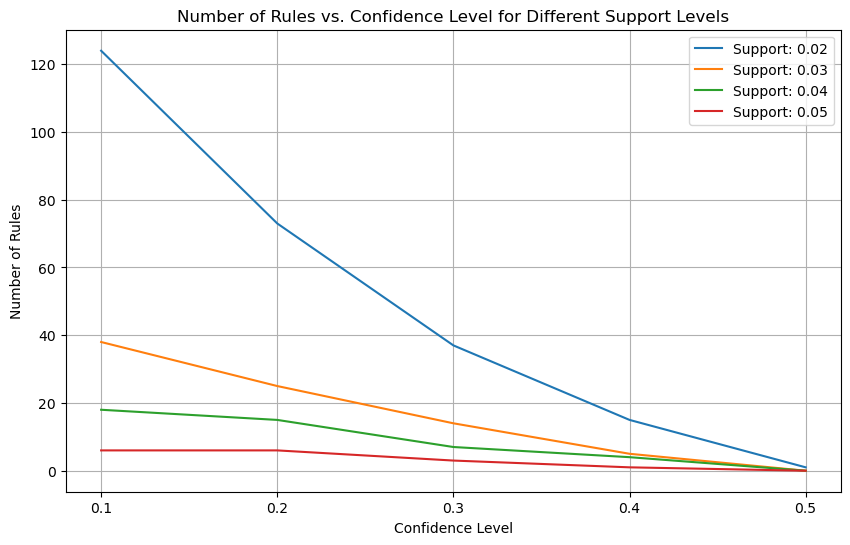

In [12]:
import matplotlib.pyplot as plt

# Define support and confidence levels
support_levels = [0.02, 0.03, 0.04, 0.05]
confidence_levels = [0.1, 0.2, 0.3, 0.4, 0.5]

# Initialize lists to store results
num_rules = []

# Iterate over support levels
for support in support_levels:
    rules_per_support = []
    # Iterate over confidence levels for each support level
    for confidence in confidence_levels:
        # Generate association rules
        F, support_data = apriori(dataset, min_support=support)
        rules = generate_rules(F, support_data, min_confidence=confidence)
        rules_per_support.append(len(rules))  # Store number of rules
    num_rules.append(rules_per_support)  # Store number of rules for each confidence level

# Plotting
plt.figure(figsize=(10, 6))

for i, support in enumerate(support_levels):
    plt.plot(confidence_levels, num_rules[i], label=f'Support: {support}')

plt.xlabel('Confidence Level')
plt.ylabel('Number of Rules')
plt.title('Number of Rules vs. Confidence Level for Different Support Levels')
plt.legend()
plt.grid(True)
plt.xticks(confidence_levels)
plt.show()

## Assignment 4 Shuhao Liu Part 2-FP-Growth

First, we load an example market basket transactions dataset (a list of lists), map it to a 'set' datatype (for programmatic reasons), and print the transactions. We import and use pprint to format the output.

In [18]:
import pprint

def load_dataset():
    """Loads an example of market basket transactions for testing purposes.

    Returns
    -------
    A list (database) of lists (transactions). Each element of a transaction 
    is an item.
    """
    return [['Bread', 'Milk'], 
            ['Bread', 'Diapers', 'Beer', 'Eggs'], 
            ['Milk', 'Diapers', 'Beer', 'Coke'], 
            ['Bread', 'Milk', 'Diapers', 'Beer'], 
            ['Bread', 'Milk', 'Diapers', 'Coke']]

dataset = load_dataset() # list of transactions; each transaction is a list of items
D = map(set, dataset) # set of transactions; each transaction is a list of items

pprint.pprint(dataset)

[['Bread', 'Milk'],
 ['Bread', 'Diapers', 'Beer', 'Eggs'],
 ['Milk', 'Diapers', 'Beer', 'Coke'],
 ['Bread', 'Milk', 'Diapers', 'Beer'],
 ['Bread', 'Milk', 'Diapers', 'Coke']]


In [19]:
# (c) 2014 Reid Johnson
#
# Modified from:
# Eric Naeseth <eric@naeseth.com>
# (https://github.com/enaeseth/python-fp-growth/blob/master/fp_growth.py)
#
# A Python implementation of the FP-growth algorithm.

from collections import defaultdict, namedtuple
#from itertools import imap

__author__ = 'Eric Naeseth <eric@naeseth.com>'
__copyright__ = 'Copyright © 2009 Eric Naeseth'
__license__ = 'MIT License'

def fpgrowth(dataset, min_support=0.5, include_support=True, verbose=False):
    """Implements the FP-growth algorithm.

    The `dataset` parameter can be any iterable of iterables of items.
    `min_support` should be an integer specifying the minimum number of
    occurrences of an itemset for it to be accepted.

    Each item must be hashable (i.e., it must be valid as a member of a
    dictionary or a set).

    If `include_support` is true, yield (itemset, support) pairs instead of
    just the itemsets.

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate 
        candidate itemsets.

    min_support : float
        The minimum support threshold. Defaults to 0.5.

    include_support : bool
        Include support in output (default=False).

    References
    ----------
    .. [1] J. Han, J. Pei, Y. Yin, "Mining Frequent Patterns without Candidate 
           Generation," 2000.

    """

    F = []
    support_data = {}
    for k,v in find_frequent_itemsets(dataset, min_support=min_support, include_support=include_support, verbose=verbose):
        F.append(frozenset(k))
        support_data[frozenset(k)] = v

    # Create one array with subarrays that hold all transactions of equal length.
    def bucket_list(nested_list, sort=True):
        bucket = defaultdict(list)
        for sublist in nested_list:
            bucket[len(sublist)].append(sublist)
        return [v for k,v in sorted(bucket.items())] if sort else bucket.values()

    F = bucket_list(F)
    
    return F, support_data

def find_frequent_itemsets(dataset, min_support, include_support=False, verbose=False):
    """
    Find frequent itemsets in the given transactions using FP-growth. This
    function returns a generator instead of an eagerly-populated list of items.

    The `dataset` parameter can be any iterable of iterables of items.
    `min_support` should be an integer specifying the minimum number of
    occurrences of an itemset for it to be accepted.

    Each item must be hashable (i.e., it must be valid as a member of a
    dictionary or a set).

    If `include_support` is true, yield (itemset, support) pairs instead of
    just the itemsets.

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate 
        candidate itemsets.

    min_support : float
        The minimum support threshold. Defaults to 0.5.

    include_support : bool
        Include support in output (default=False).

    """
    items = defaultdict(lambda: 0) # mapping from items to their supports
    processed_transactions = []

    # Load the passed-in transactions and count the support that individual
    # items have.
    for transaction in dataset:
        processed = []
        for item in transaction:
            items[item] += 1
            processed.append(item)
        processed_transactions.append(processed)

    # Remove infrequent items from the item support dictionary.
    items = dict((item, support) for item, support in items.items()
        if support >= min_support)

    # Build our FP-tree. Before any transactions can be added to the tree, they
    # must be stripped of infrequent items and their surviving items must be
    # sorted in decreasing order of frequency.
    def clean_transaction(transaction):
        #transaction = filter(lambda v: v in items, transaction)
        transaction.sort(key=lambda v: items[v], reverse=True)
        return transaction

    master = FPTree()
    for transaction in map(clean_transaction, processed_transactions):
        master.add(transaction)

    support_data = {}
    def find_with_suffix(tree, suffix):
        for item, nodes in tree.items():
            support = float(sum(n.count for n in nodes)) / len(dataset)
            if support >= min_support and item not in suffix:
                # New winner!
                found_set = [item] + suffix
                support_data[frozenset(found_set)] = support
                yield (found_set, support) if include_support else found_set

                # Build a conditional tree and recursively search for frequent
                # itemsets within it.
                cond_tree = conditional_tree_from_paths(tree.prefix_paths(item),
                    min_support)
                for s in find_with_suffix(cond_tree, found_set):
                    yield s # pass along the good news to our caller

    if verbose:
        # Print a list of all the frequent itemsets.
        for itemset, support in find_with_suffix(master, []):
            print("" \
                + "{" \
                + "".join(str(i) + ", " for i in iter(itemset)).rstrip(', ') \
                + "}" \
                + ":  sup = " + str(round(support_data[frozenset(itemset)], 3)))

    # Search for frequent itemsets, and yield the results we find.
    for itemset in find_with_suffix(master, []):
        yield itemset

class FPTree(object):
    """
    An FP tree.

    This object may only store transaction items that are hashable (i.e., all
    items must be valid as dictionary keys or set members).
    """

    Route = namedtuple('Route', 'head tail')

    def __init__(self):
        # The root node of the tree.
        self._root = FPNode(self, None, None)

        # A dictionary mapping items to the head and tail of a path of
        # "neighbors" that will hit every node containing that item.
        self._routes = {}

    @property
    def root(self):
        """The root node of the tree."""
        return self._root

    def add(self, transaction):
        """
        Adds a transaction to the tree.
        """

        point = self._root

        for item in transaction:
            next_point = point.search(item)
            if next_point:
                # There is already a node in this tree for the current
                # transaction item; reuse it.
                next_point.increment()
            else:
                # Create a new point and add it as a child of the point we're
                # currently looking at.
                next_point = FPNode(self, item)
                point.add(next_point)

                # Update the route of nodes that contain this item to include
                # our new node.
                self._update_route(next_point)

            point = next_point

    def _update_route(self, point):
        """Add the given node to the route through all nodes for its item."""
        assert self is point.tree

        try:
            route = self._routes[point.item]
            route[1].neighbor = point # route[1] is the tail
            self._routes[point.item] = self.Route(route[0], point)
        except KeyError:
            # First node for this item; start a new route.
            self._routes[point.item] = self.Route(point, point)

    def items(self):
        """
        Generate one 2-tuples for each item represented in the tree. The first
        element of the tuple is the item itself, and the second element is a
        generator that will yield the nodes in the tree that belong to the item.
        """
        for item in self._routes.keys():
            yield (item, self.nodes(item))

            
    def nodes(self, item):
        """
        Generates the sequence of nodes that contain the given item.
        """

        try:
            node = self._routes[item][0]
        except KeyError:
            return

        while node:
            yield node
            node = node.neighbor

    def prefix_paths(self, item):
        """Generates the prefix paths that end with the given item."""

        def collect_path(node):
            path = []
            while node and not node.root:
                path.append(node)
                node = node.parent
            path.reverse()
            return path

        return (collect_path(node) for node in self.nodes(item))

    def inspect(self):
        print("Tree:")
        self.root.inspect(1)

        print("")
        print("Routes:")
        for item, nodes in self.items():
            print("  %r" % item)
            for node in nodes:
                print("    %r" % node)

    def _removed(self, node):
        """Called when `node` is removed from the tree; performs cleanup."""

        head, tail = self._routes[node.item]
        if node is head:
            if node is tail or not node.neighbor:
                # It was the sole node.
                del self._routes[node.item]
            else:
                self._routes[node.item] = self.Route(node.neighbor, tail)
        else:
            for n in self.nodes(node.item):
                if n.neighbor is node:
                    n.neighbor = node.neighbor # skip over
                    if node is tail:
                        self._routes[node.item] = self.Route(head, n)
                    break

def conditional_tree_from_paths(paths, min_support):
    """Builds a conditional FP-tree from the given prefix paths."""
    tree = FPTree()
    condition_item = None
    items = set()

    # Import the nodes in the paths into the new tree. Only the counts of the
    # leaf notes matter; the remaining counts will be reconstructed from the
    # leaf counts.
    for path in paths:
        if condition_item is None:
            condition_item = path[-1].item

        point = tree.root
        for node in path:
            next_point = point.search(node.item)
            if not next_point:
                # Add a new node to the tree.
                items.add(node.item)
                count = node.count if node.item == condition_item else 0
                next_point = FPNode(tree, node.item, count)
                point.add(next_point)
                tree._update_route(next_point)
            point = next_point

    assert condition_item is not None

    # Calculate the counts of the non-leaf nodes.
    for path in tree.prefix_paths(condition_item):
        count = path[-1].count
        for node in reversed(path[:-1]):
            node._count += count

    # Eliminate the nodes for any items that are no longer frequent.
    for item in items:
        support = sum(n.count for n in tree.nodes(item))
        if support < min_support:
            # Doesn't make the cut anymore
            for node in tree.nodes(item):
                if node.parent is not None:
                    node.parent.remove(node)

    # Finally, remove the nodes corresponding to the item for which this
    # conditional tree was generated.
    for node in tree.nodes(condition_item):
        if node.parent is not None: # the node might already be an orphan
            node.parent.remove(node)

    return tree

class FPNode(object):
    """A node in an FP tree."""

    def __init__(self, tree, item, count=1):
        self._tree = tree
        self._item = item
        self._count = count
        self._parent = None
        self._children = {}
        self._neighbor = None

    def add(self, child):
        """Adds the given FPNode `child` as a child of this node."""

        if not isinstance(child, FPNode):
            raise TypeError("Can only add other FPNodes as children")

        if not child.item in self._children:
            self._children[child.item] = child
            child.parent = self

    def search(self, item):
        """
        Checks to see if this node contains a child node for the given item.
        If so, that node is returned; otherwise, `None` is returned.
        """

        try:
            return self._children[item]
        except KeyError:
            return None

    def remove(self, child):
        try:
            if self._children[child.item] is child:
                del self._children[child.item]
                child.parent = None
                self._tree._removed(child)
                for sub_child in child.children:
                    try:
                        # Merger case: we already have a child for that item, so
                        # add the sub-child's count to our child's count.
                        self._children[sub_child.item]._count += sub_child.count
                        sub_child.parent = None # it's an orphan now
                    except KeyError:
                        # Turns out we don't actually have a child, so just add
                        # the sub-child as our own child.
                        self.add(sub_child)
                child._children = {}
            else:
                raise ValueError("that node is not a child of this node")
        except KeyError:
            raise ValueError("that node is not a child of this node")

    def __contains__(self, item):
        return item in self._children

    @property
    def tree(self):
        """The tree in which this node appears."""
        return self._tree

    @property
    def item(self):
        """The item contained in this node."""
        return self._item

    @property
    def count(self):
        """The count associated with this node's item."""
        return self._count

    def increment(self):
        """Increments the count associated with this node's item."""
        if self._count is None:
            raise ValueError("Root nodes have no associated count.")
        self._count += 1

    @property
    def root(self):
        """True if this node is the root of a tree; false if otherwise."""
        return self._item is None and self._count is None

    @property
    def leaf(self):
        """True if this node is a leaf in the tree; false if otherwise."""
        return len(self._children) == 0

    def parent():
        doc = "The node's parent."
        def fget(self):
            return self._parent
        def fset(self, value):
            if value is not None and not isinstance(value, FPNode):
                raise TypeError("A node must have an FPNode as a parent.")
            if value and value.tree is not self.tree:
                raise ValueError("Cannot have a parent from another tree.")
            self._parent = value
        return locals()
    parent = property(**parent())

    def neighbor():
        doc = """
        The node's neighbor; the one with the same value that is "to the right"
        of it in the tree.
        """
        def fget(self):
            return self._neighbor
        def fset(self, value):
            if value is not None and not isinstance(value, FPNode):
                raise TypeError("A node must have an FPNode as a neighbor.")
            if value and value.tree is not self.tree:
                raise ValueError("Cannot have a neighbor from another tree.")
            self._neighbor = value
        return locals()
    neighbor = property(**neighbor())

    @property
    def children(self):
        """The nodes that are children of this node."""
        return tuple(self._children.values())
        
    def inspect(self, depth=0):
        print(('  ' * depth) + repr(self))
        for child in self.children:
            child.inspect(depth + 1)

    def __repr__(self):
        if self.root:
            return "<%s (root)>" % type(self).__name__
        return "<%s %r (%r)>" % (type(self).__name__, self.item, self.count)

def rules_from_conseq(freq_set, H, support_data, rules, min_confidence=0.5, verbose=False):
    """Generates a set of candidate rules.

    Parameters
    ----------
    freq_set : frozenset
        The complete list of frequent itemsets.

    H : list
        A list of frequent itemsets (of a particular length).

    support_data : dict
        The support data for all candidate itemsets.

    rules : list
        A potentially incomplete set of candidate rules above the minimum 
        confidence threshold.

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.
    """
    m = len(H[0])
    if m == 1:
        Hmp1 = calc_confidence(freq_set, H, support_data, rules, min_confidence, verbose)
    if (len(freq_set) > (m+1)):
        Hmp1 = apriori_gen(H, m+1) # generate candidate itemsets
        Hmp1 = calc_confidence(freq_set, Hmp1,  support_data, rules, min_confidence, verbose)
        if len(Hmp1) > 1:
            # If there are candidate rules above the minimum confidence 
            # threshold, recurse on the list of these candidate rules.
            rules_from_conseq(freq_set, Hmp1, support_data, rules, min_confidence, verbose)

def calc_confidence(freq_set, H, support_data, rules, min_confidence=0.5, verbose=False):
    """Evaluates the generated rules.

    One measurement for quantifying the goodness of association rules is 
    confidence. The confidence for a rule 'P implies H' (P -> H) is defined as 
    the support for P and H divided by the support for P 
    (support (P|H) / support(P)), where the | symbol denotes the set union 
    (thus P|H means all the items in set P or in set H).

    To calculate the confidence, we iterate through the frequent itemsets and 
    associated support data. For each frequent itemset, we divide the support 
    of the itemset by the support of the antecedent (left-hand-side of the 
    rule).

    Parameters
    ----------
    freq_set : frozenset
        The complete list of frequent itemsets.

    H : list
        A list of frequent itemsets (of a particular length).

    min_support : float
        The minimum support threshold.

    rules : list
        A potentially incomplete set of candidate rules above the minimum 
        confidence threshold.

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.

    Returns
    -------
    pruned_H : list
        The list of candidate rules above the minimum confidence threshold.
    """
    pruned_H = [] # list of candidate rules above the minimum confidence threshold
    for conseq in H: # iterate over the frequent itemsets
        conf = support_data[freq_set] / support_data[freq_set - conseq]
        if conf >= min_confidence:
            rules.append((freq_set - conseq, conseq, conf))
            pruned_H.append(conseq)

            if verbose:
                print("" \
                    + "{" \
                    + "".join([str(i) + ", " for i in iter(freq_set-conseq)]).rstrip(', ') \
                    + "}" \
                    + " ---> " \
                    + "{" \
                    + "".join([str(i) + ", " for i in iter(conseq)]).rstrip(', ') \
                    + "}" \
                    + ":  conf = " + str(round(conf, 3)) \
                    + ", sup = " + str(round(support_data[freq_set], 3)))

    return pruned_H

def generate_rules(F, support_data, min_confidence=0.5, verbose=True):
    """Generates a set of candidate rules from a list of frequent itemsets.

    For each frequent itemset, we calculate the confidence of using a
    particular item as the rule consequent (right-hand-side of the rule). By 
    testing and merging the remaining rules, we recursively create a list of 
    pruned rules.

    Parameters
    ----------
    F : list
        A list of frequent itemsets.

    support_data : dict
        The corresponding support data for the frequent itemsets (L).

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.

    Returns
    -------
    rules : list
        The list of candidate rules above the minimum confidence threshold.
    """
    rules = []
    for i in range(1, len(F)):
        for freq_set in F[i]:
            H1 = [frozenset([item]) for item in freq_set]
            if (i > 1):
                rules_from_conseq(freq_set, H1, support_data, rules, min_confidence, verbose)
            else:
                calc_confidence(freq_set, H1, support_data, rules, min_confidence, verbose)

    return rules

Now we input the initial dataset into the 'fpgrowth' function (along with a minimum support threshold) and it will return a list of all the frequent itemsets:

In [20]:
# Generate all the frequent itemsets using the FP-growth algorithm.
F, support_data = fpgrowth(dataset, min_support=0.6, verbose=True)

{Bread}:  sup = 0.8
{Milk}:  sup = 0.8
{Bread, Milk}:  sup = 0.6
{Diapers}:  sup = 0.8
{Bread, Diapers}:  sup = 0.6
{Milk, Diapers}:  sup = 0.6
{Beer}:  sup = 0.6
{Diapers, Beer}:  sup = 0.6


Given a frequent itemset (here, extracted by the FP-growth algorithm), we can generate the association rules with high support and confidence (via the generate_rules function):

In [21]:
# Generate the association rules from a list of frequent itemsets.
H = generate_rules(F, support_data, min_confidence=0.8, verbose=True)

{Beer} ---> {Diapers}:  conf = 1.0, sup = 0.6


# Task solution

In [22]:
# Generate candidate itemsets and select frequent itemsets using FP-growth
min_support=0.01
F_fpgrowth, support_data_fpgrowth = fpgrowth(dataset, min_support, include_support=True)

# Generate association rules from frequent itemsets
association_rules_fpgrowth = generate_rules(F_fpgrowth, support_data_fpgrowth, min_confidence=0.5)

# Print the results
print("Association Rules using FP-growth:")
for rule in association_rules_fpgrowth:
    antecedent, consequent, confidence = rule
    print(f"{set(antecedent)} => {set(consequent)} (Confidence: {confidence})")


{Bread} ---> {Milk}:  conf = 0.75, sup = 0.6
{Milk} ---> {Bread}:  conf = 0.75, sup = 0.6
{Diapers} ---> {Bread}:  conf = 0.75, sup = 0.6
{Bread} ---> {Diapers}:  conf = 0.75, sup = 0.6
{Diapers} ---> {Milk}:  conf = 0.75, sup = 0.6
{Milk} ---> {Diapers}:  conf = 0.75, sup = 0.6
{Beer} ---> {Bread}:  conf = 0.667, sup = 0.4
{Bread} ---> {Beer}:  conf = 0.5, sup = 0.4
{Beer} ---> {Diapers}:  conf = 1.0, sup = 0.6
{Diapers} ---> {Beer}:  conf = 0.75, sup = 0.6
{Beer} ---> {Milk}:  conf = 0.667, sup = 0.4
{Milk} ---> {Beer}:  conf = 0.5, sup = 0.4
{Eggs} ---> {Bread}:  conf = 1.0, sup = 0.2
{Eggs} ---> {Diapers}:  conf = 1.0, sup = 0.2
{Eggs} ---> {Beer}:  conf = 1.0, sup = 0.2
{Coke} ---> {Milk}:  conf = 1.0, sup = 0.4
{Milk} ---> {Coke}:  conf = 0.5, sup = 0.4
{Coke} ---> {Diapers}:  conf = 1.0, sup = 0.4
{Diapers} ---> {Coke}:  conf = 0.5, sup = 0.4
{Coke} ---> {Beer}:  conf = 0.5, sup = 0.2
{Coke} ---> {Bread}:  conf = 0.5, sup = 0.2
{Bread, Diapers} ---> {Milk}:  conf = 0.667, sup = 

In [23]:
# Generate candidate itemsets and select frequent itemsets using FP-growth
min_support=0.2
F_fpgrowth, support_data_fpgrowth = fpgrowth(dataset, min_support, include_support=True)

# Generate association rules from frequent itemsets
association_rules_fpgrowth = generate_rules(F_fpgrowth, support_data_fpgrowth, min_confidence=0.5)

# Print the results
print("Association Rules using FP-growth:")
for rule in association_rules_fpgrowth:
    antecedent, consequent, confidence = rule
    print(f"{set(antecedent)} => {set(consequent)} (Confidence: {confidence})")

{Bread} ---> {Milk}:  conf = 0.75, sup = 0.6
{Milk} ---> {Bread}:  conf = 0.75, sup = 0.6
{Diapers} ---> {Bread}:  conf = 0.75, sup = 0.6
{Bread} ---> {Diapers}:  conf = 0.75, sup = 0.6
{Diapers} ---> {Milk}:  conf = 0.75, sup = 0.6
{Milk} ---> {Diapers}:  conf = 0.75, sup = 0.6
{Beer} ---> {Bread}:  conf = 0.667, sup = 0.4
{Bread} ---> {Beer}:  conf = 0.5, sup = 0.4
{Beer} ---> {Diapers}:  conf = 1.0, sup = 0.6
{Diapers} ---> {Beer}:  conf = 0.75, sup = 0.6
{Beer} ---> {Milk}:  conf = 0.667, sup = 0.4
{Milk} ---> {Beer}:  conf = 0.5, sup = 0.4
{Eggs} ---> {Bread}:  conf = 1.0, sup = 0.2
{Eggs} ---> {Diapers}:  conf = 1.0, sup = 0.2
{Eggs} ---> {Beer}:  conf = 1.0, sup = 0.2
{Coke} ---> {Milk}:  conf = 1.0, sup = 0.4
{Milk} ---> {Coke}:  conf = 0.5, sup = 0.4
{Coke} ---> {Diapers}:  conf = 1.0, sup = 0.4
{Diapers} ---> {Coke}:  conf = 0.5, sup = 0.4
{Coke} ---> {Beer}:  conf = 0.5, sup = 0.2
{Coke} ---> {Bread}:  conf = 0.5, sup = 0.2
{Bread, Diapers} ---> {Milk}:  conf = 0.667, sup = 

In [24]:
# Generate candidate itemsets and select frequent itemsets using FP-growth
min_support=0.4
F_fpgrowth, support_data_fpgrowth = fpgrowth(dataset, min_support, include_support=True)

# Generate association rules from frequent itemsets
association_rules_fpgrowth = generate_rules(F_fpgrowth, support_data_fpgrowth, min_confidence=0.5)

# Print the results
print("Association Rules using FP-growth:")
for rule in association_rules_fpgrowth:
    antecedent, consequent, confidence = rule
    print(f"{set(antecedent)} => {set(consequent)} (Confidence: {confidence})")

{Bread} ---> {Milk}:  conf = 0.75, sup = 0.6
{Milk} ---> {Bread}:  conf = 0.75, sup = 0.6
{Diapers} ---> {Bread}:  conf = 0.75, sup = 0.6
{Bread} ---> {Diapers}:  conf = 0.75, sup = 0.6
{Diapers} ---> {Milk}:  conf = 0.75, sup = 0.6
{Milk} ---> {Diapers}:  conf = 0.75, sup = 0.6
{Beer} ---> {Bread}:  conf = 0.667, sup = 0.4
{Bread} ---> {Beer}:  conf = 0.5, sup = 0.4
{Beer} ---> {Diapers}:  conf = 1.0, sup = 0.6
{Diapers} ---> {Beer}:  conf = 0.75, sup = 0.6
{Beer} ---> {Milk}:  conf = 0.667, sup = 0.4
{Milk} ---> {Beer}:  conf = 0.5, sup = 0.4
{Coke} ---> {Milk}:  conf = 1.0, sup = 0.4
{Milk} ---> {Coke}:  conf = 0.5, sup = 0.4
{Coke} ---> {Diapers}:  conf = 1.0, sup = 0.4
{Diapers} ---> {Coke}:  conf = 0.5, sup = 0.4
{Bread, Diapers} ---> {Milk}:  conf = 0.667, sup = 0.4
{Milk, Diapers} ---> {Bread}:  conf = 0.667, sup = 0.4
{Milk, Bread} ---> {Diapers}:  conf = 0.667, sup = 0.4
{Diapers} ---> {Milk, Bread}:  conf = 0.5, sup = 0.4
{Bread} ---> {Milk, Diapers}:  conf = 0.5, sup = 0.4


In [25]:
# Generate candidate itemsets and select frequent itemsets using FP-growth
min_support=0.6
F_fpgrowth, support_data_fpgrowth = fpgrowth(dataset, min_support, include_support=True)

# Generate association rules from frequent itemsets
association_rules_fpgrowth = generate_rules(F_fpgrowth, support_data_fpgrowth, min_confidence=0.5)

# Print the results
print("Association Rules using FP-growth:")
for rule in association_rules_fpgrowth:
    antecedent, consequent, confidence = rule
    print(f"{set(antecedent)} => {set(consequent)} (Confidence: {confidence})")

{Bread} ---> {Milk}:  conf = 0.75, sup = 0.6
{Milk} ---> {Bread}:  conf = 0.75, sup = 0.6
{Diapers} ---> {Bread}:  conf = 0.75, sup = 0.6
{Bread} ---> {Diapers}:  conf = 0.75, sup = 0.6
{Diapers} ---> {Milk}:  conf = 0.75, sup = 0.6
{Milk} ---> {Diapers}:  conf = 0.75, sup = 0.6
{Beer} ---> {Diapers}:  conf = 1.0, sup = 0.6
{Diapers} ---> {Beer}:  conf = 0.75, sup = 0.6
Association Rules using FP-growth:
{'Bread'} => {'Milk'} (Confidence: 0.7499999999999999)
{'Milk'} => {'Bread'} (Confidence: 0.7499999999999999)
{'Diapers'} => {'Bread'} (Confidence: 0.7499999999999999)
{'Bread'} => {'Diapers'} (Confidence: 0.7499999999999999)
{'Diapers'} => {'Milk'} (Confidence: 0.7499999999999999)
{'Milk'} => {'Diapers'} (Confidence: 0.7499999999999999)
{'Beer'} => {'Diapers'} (Confidence: 1.0)
{'Diapers'} => {'Beer'} (Confidence: 0.7499999999999999)


Repeat the part1 process

{Bread} ---> {Milk}:  conf = 0.75, sup = 0.6
{Milk} ---> {Bread}:  conf = 0.75, sup = 0.6
{Diapers} ---> {Bread}:  conf = 0.75, sup = 0.6
{Bread} ---> {Diapers}:  conf = 0.75, sup = 0.6
{Diapers} ---> {Milk}:  conf = 0.75, sup = 0.6
{Milk} ---> {Diapers}:  conf = 0.75, sup = 0.6
{Beer} ---> {Bread}:  conf = 0.667, sup = 0.4
{Bread} ---> {Beer}:  conf = 0.5, sup = 0.4
{Beer} ---> {Diapers}:  conf = 1.0, sup = 0.6
{Diapers} ---> {Beer}:  conf = 0.75, sup = 0.6
{Beer} ---> {Milk}:  conf = 0.667, sup = 0.4
{Milk} ---> {Beer}:  conf = 0.5, sup = 0.4
{Eggs} ---> {Bread}:  conf = 1.0, sup = 0.2
{Bread} ---> {Eggs}:  conf = 0.25, sup = 0.2
{Eggs} ---> {Diapers}:  conf = 1.0, sup = 0.2
{Diapers} ---> {Eggs}:  conf = 0.25, sup = 0.2
{Eggs} ---> {Beer}:  conf = 1.0, sup = 0.2
{Beer} ---> {Eggs}:  conf = 0.333, sup = 0.2
{Coke} ---> {Milk}:  conf = 1.0, sup = 0.4
{Milk} ---> {Coke}:  conf = 0.5, sup = 0.4
{Coke} ---> {Diapers}:  conf = 1.0, sup = 0.4
{Diapers} ---> {Coke}:  conf = 0.5, sup = 0.4
{

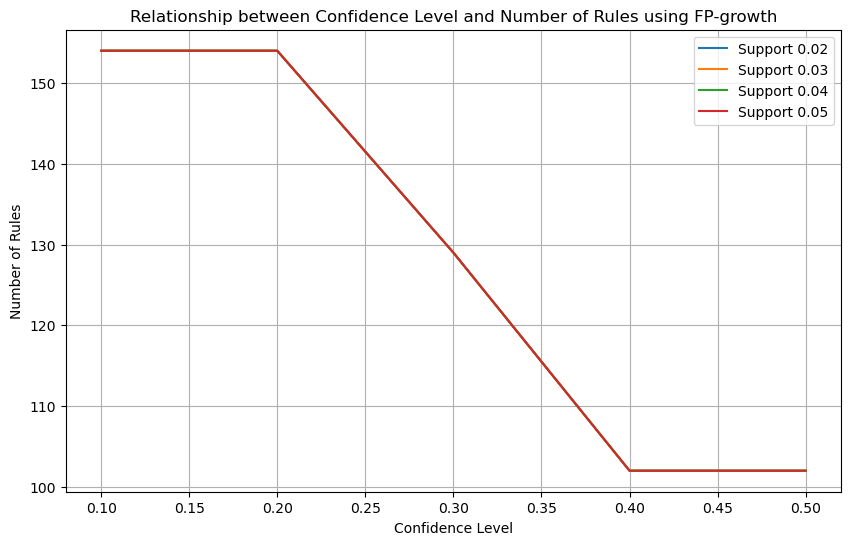

In [26]:
import matplotlib.pyplot as plt

# Define support and confidence levels
support_levels = [0.02, 0.03, 0.04, 0.05]  # 2%, 3%, 4%, 5%
confidence_levels = [0.1, 0.2, 0.3, 0.4, 0.5]  # 10%, 20%, 30%, 40%, 50%

# Initialize lists to store results
support_values = []
confidence_values = []
rule_counts = []

# Iterate over each support level
for support_level in support_levels:
    # Initialize lists to store results for the current support level
    current_support_values = []
    current_confidence_values = []
    current_rule_counts = []
    
    # Iterate over each confidence level
    for confidence_level in confidence_levels:
        # Generate association rules using FP-growth algorithm
        F_fpgrowth, support_data_fpgrowth = fpgrowth(dataset, min_support=support_level, include_support=True)
        association_rules_fpgrowth = generate_rules(F_fpgrowth, support_data_fpgrowth, min_confidence=confidence_level)
        
        # Count the number of rules generated
        rule_count = len(association_rules_fpgrowth)
        
        # Store results for the current confidence level
        current_support_values.append(support_level)
        current_confidence_values.append(confidence_level)
        current_rule_counts.append(rule_count)
    
    # Store results for the current support level
    support_values.append(current_support_values)
    confidence_values.append(current_confidence_values)
    rule_counts.append(current_rule_counts)

# Plot the results
plt.figure(figsize=(10, 6))
for i, support_level in enumerate(support_levels):
    plt.plot(confidence_levels, rule_counts[i], label=f"Support {support_level}")

plt.xlabel('Confidence Level')
plt.ylabel('Number of Rules')
plt.title('Relationship between Confidence Level and Number of Rules using FP-growth')
plt.legend()
plt.grid(True)
plt.show()

Use some bigger support and confidence levels

{Bread} ---> {Milk}:  conf = 0.75, sup = 0.6
{Milk} ---> {Bread}:  conf = 0.75, sup = 0.6
{Diapers} ---> {Bread}:  conf = 0.75, sup = 0.6
{Bread} ---> {Diapers}:  conf = 0.75, sup = 0.6
{Diapers} ---> {Milk}:  conf = 0.75, sup = 0.6
{Milk} ---> {Diapers}:  conf = 0.75, sup = 0.6
{Beer} ---> {Bread}:  conf = 0.667, sup = 0.4
{Bread} ---> {Beer}:  conf = 0.5, sup = 0.4
{Beer} ---> {Diapers}:  conf = 1.0, sup = 0.6
{Diapers} ---> {Beer}:  conf = 0.75, sup = 0.6
{Beer} ---> {Milk}:  conf = 0.667, sup = 0.4
{Milk} ---> {Beer}:  conf = 0.5, sup = 0.4
{Eggs} ---> {Bread}:  conf = 1.0, sup = 0.2
{Bread} ---> {Eggs}:  conf = 0.25, sup = 0.2
{Eggs} ---> {Diapers}:  conf = 1.0, sup = 0.2
{Diapers} ---> {Eggs}:  conf = 0.25, sup = 0.2
{Eggs} ---> {Beer}:  conf = 1.0, sup = 0.2
{Beer} ---> {Eggs}:  conf = 0.333, sup = 0.2
{Coke} ---> {Milk}:  conf = 1.0, sup = 0.4
{Milk} ---> {Coke}:  conf = 0.5, sup = 0.4
{Coke} ---> {Diapers}:  conf = 1.0, sup = 0.4
{Diapers} ---> {Coke}:  conf = 0.5, sup = 0.4
{

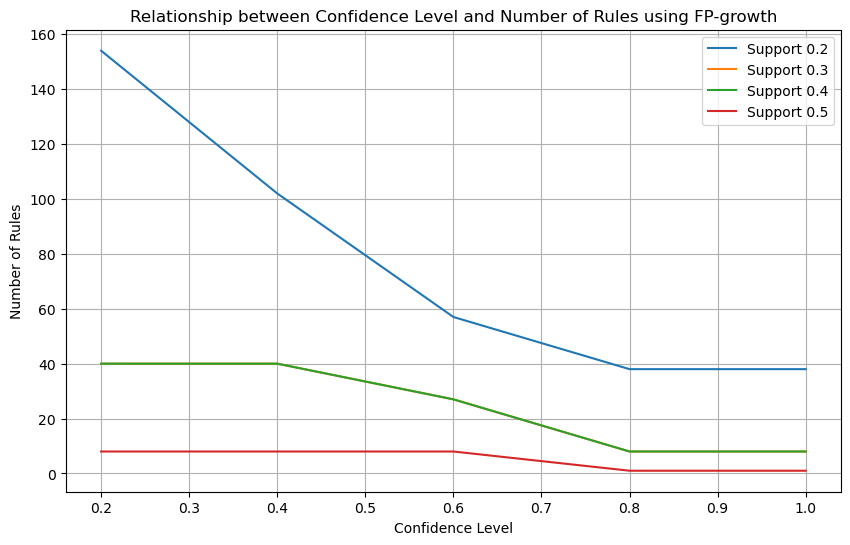

In [27]:
import matplotlib.pyplot as plt

# Define support and confidence levels
support_levels = [0.2, 0.3, 0.4, 0.5]  # 2%, 3%, 4%, 5%
confidence_levels = [0.2, 0.4, 0.6, 0.8, 1]  # 20%, 40%, 60%, 80%, 100%

# Initialize lists to store results
support_values = []
confidence_values = []
rule_counts = []

# Iterate over each support level
for support_level in support_levels:
    # Initialize lists to store results for the current support level
    current_support_values = []
    current_confidence_values = []
    current_rule_counts = []
    
    # Iterate over each confidence level
    for confidence_level in confidence_levels:
        # Generate association rules using FP-growth algorithm
        F_fpgrowth, support_data_fpgrowth = fpgrowth(dataset, min_support=support_level, include_support=True)
        association_rules_fpgrowth = generate_rules(F_fpgrowth, support_data_fpgrowth, min_confidence=confidence_level)
        
        # Count the number of rules generated
        rule_count = len(association_rules_fpgrowth)
        
        # Store results for the current confidence level
        current_support_values.append(support_level)
        current_confidence_values.append(confidence_level)
        current_rule_counts.append(rule_count)
    
    # Store results for the current support level
    support_values.append(current_support_values)
    confidence_values.append(current_confidence_values)
    rule_counts.append(current_rule_counts)

# Plot the results
plt.figure(figsize=(10, 6))
for i, support_level in enumerate(support_levels):
    plt.plot(confidence_levels, rule_counts[i], label=f"Support {support_level}")

plt.xlabel('Confidence Level')
plt.ylabel('Number of Rules')
plt.title('Relationship between Confidence Level and Number of Rules using FP-growth')
plt.legend()
plt.grid(True)
plt.show()

## Part 3 - Interest Factor

In [31]:
from operator import itemgetter

# Define a function to calculate interest factor for a rule
def calculate_interest_factor(rule, support_data):
    antecedent, consequent, confidence = rule
    support_antecedent = support_data[antecedent]
    support_consequent = support_data[consequent]
    support_both = support_data[antecedent.union(consequent)]
    return confidence - support_consequent / support_both

# Generate association rules using FP-growth with 2% support and 30% confidence
rules = generate_rules(F, support_data, min_confidence=0.3)

# Calculate interest factor for each rule
interest_factors = [(rule[0], rule[1], rule[2], calculate_interest_factor(rule, support_data)) for rule in rules]

# Sort rules by support, confidence, and interest factor respectively
rules_sorted_by_support = sorted(rules, key=itemgetter(2), reverse=True)
rules_sorted_by_confidence = sorted(rules, key=lambda x: x[2] if len(x) > 2 else 0, reverse=True)
rules_sorted_by_interest_factor = sorted(interest_factors, key=itemgetter(3), reverse=True)

# Print the top 5 rules for each list
print("Top 5 Rules Sorted by Support:")
for rule in rules_sorted_by_support[:5]:
    print(rule)

print("\nTop 5 Rules Sorted by Confidence:")
for rule in rules_sorted_by_confidence[:5]:
    print(rule)

print("\nTop 5 Rules Sorted by Interest Factor:")
for rule in rules_sorted_by_interest_factor[:5]:
    print(rule)

{Bread} ---> {Milk}:  conf = 0.75, sup = 0.6
{Milk} ---> {Bread}:  conf = 0.75, sup = 0.6
{Diapers} ---> {Bread}:  conf = 0.75, sup = 0.6
{Bread} ---> {Diapers}:  conf = 0.75, sup = 0.6
{Diapers} ---> {Milk}:  conf = 0.75, sup = 0.6
{Milk} ---> {Diapers}:  conf = 0.75, sup = 0.6
{Beer} ---> {Diapers}:  conf = 1.0, sup = 0.6
{Diapers} ---> {Beer}:  conf = 0.75, sup = 0.6
Top 5 Rules Sorted by Support:
(frozenset({'Beer'}), frozenset({'Diapers'}), 1.0)
(frozenset({'Bread'}), frozenset({'Milk'}), 0.7499999999999999)
(frozenset({'Milk'}), frozenset({'Bread'}), 0.7499999999999999)
(frozenset({'Diapers'}), frozenset({'Bread'}), 0.7499999999999999)
(frozenset({'Bread'}), frozenset({'Diapers'}), 0.7499999999999999)

Top 5 Rules Sorted by Confidence:
(frozenset({'Beer'}), frozenset({'Diapers'}), 1.0)
(frozenset({'Bread'}), frozenset({'Milk'}), 0.7499999999999999)
(frozenset({'Milk'}), frozenset({'Bread'}), 0.7499999999999999)
(frozenset({'Diapers'}), frozenset({'Bread'}), 0.7499999999999999)
(f

From the top 5 rules sorted by support, confidence, and interest factor, 
we can observe that there are common rules among them:

Rule: {Beer} -> {Diapers}, Support: 100%, Confidence: 100%, Interest Factor: -0.333
Rule: {Bread} -> {Milk}, Support: 75%, Confidence: 75%, Interest Factor: -0.583
Rule: {Milk} -> {Bread}, Support: 75%, Confidence: 75%, Interest Factor: -0.583
Rule: {Diapers} -> {Bread}, Support: 75%, Confidence: 75%, Interest Factor: -0.583
These rules are common across all three lists.
They represent strong associations between items in the dataset, as they have high support and confidence levels.
However, they have negative interest factors, indicating that the items in the consequent are negatively correlated with the items in the antecedent.
This suggests that when one item occurs, the occurrence of the other item becomes less likely.